# ProductNet: Categorize products using image(s) and text descriptors
## Jen Sheng Wong and Kartik Nanda (Cohort 14)
Based on following paper: https://arxiv.org/pdf/1904.09037.pdf

## Problem Statement:
Relates primarily to products on retail/marketplace sites such as Amazon. The problem deals with 3 main aspects:
* Trying to categorize products. Number of categories ~5000 (using the Google taxonomy: https://github.com/fellowship/platform-demos3/blob/master/ProductNet/taxonomy-with-ids.en-US.xls)
* Product has images (1 or more)
* Product has text - title, description, keywords

Possible end-problems to solve: 
a) Find the category, given product images and user provided text description. 
b) Find mis-categorized products

## Dataset: 
Products for sale on Amazon; product details from 1996 through 2014, by Prof. McAuley at UCSD
Citations:
* R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016
* J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015

## Dataset Storage:
* Used Google storage bucket located at gs://platform-ai-research/datasets/ProductNet/
* Also used Jen Sheng's Google Drive for intermediate files, images etc

In [1]:
!pip install fastai
!pip install pyarrow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import gc
from tqdm import tqdm

from PIL import Image

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

## Cleaning the Dataset
Our initial challenges were dealing with the dataset. 
* Its 9.5 million entries. Many of them we can not easily use (example Books, Videos etc). Initial steps: dealing with the size and the initial cleaning - these are captured in a separate script: https://github.com/fellowship/platform-demos3/blob/master/ProductNet/workbook_1.ipynb
* Clean up the category, names - reduce the number of categories we are dealing with. In the beginning only 40 categories. This is probably not ideal because the categories are very high level, and it might actually result in worse numbers.
* Data distribution across categories is not balanced. Decided to sub-sample, which has 2 benefits: a) Reduces the size of the dataset to something more manageable (from 6.5 million at the and of step 1); b) provides a balanced distribution between the various categories
* Download the image files using the urls in the dataset. These were stored in Google Drive. Missing instances were removed from the dataset.

In [0]:
# Set the file name - this is the output file from step1 (workbook_1)
file_name = 'metadata_clean_0513'

# set local to False if running on Colab
local = False      # this needs to be automated (how?)

# Reading in the datafile
exists = os.path.isfile(file_name)
if (not exists):
    if (not local):
        # Login to access the GS bucket
        from google.colab import auth
        auth.authenticate_user()

        # Copy the datafile to the Colab local dir
        gs_path = 'platform-ai-research/datasets/ProductNet/'
        remote_file = gs_path + file_name
        !gsutil cp gs://{remote_file} {file_name}
                
    else: 
        print('File Does Not Exist')
        sys.exit()

# Read in the file
df = pd.read_feather(file_name)

# # Drop records with missing labels
# df.dropna(subset=['label'], inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5607160 entries, 0 to 5607159
Data columns (total 7 columns):
index          int64
asin           object
categories     object
description    object
imUrl          object
title          object
label          object
dtypes: int64(1), object(6)
memory usage: 299.5+ MB


In [4]:
# See the distribution of the categories
xx = np.array([])
yy = np.array([])
for l in df.label.unique():
    i = len(df[df.label == l])
    print('label = ', l, ' Number of instances = ', str(i))
    xx = np.append(xx,[l])
    yy = np.append(yy,[i])

label =  Clothing  Number of instances =  1435827
label =  Sports & Outdoors  Number of instances =  529408
label =  Toys & Games  Number of instances =  334199
label =  Musical Instruments  Number of instances =  67513
label =  Tools & Home Improvement  Number of instances =  268464
label =  Home & Kitchen  Number of instances =  436927
label =  Health & Personal Care  Number of instances =  262304
label =  Cell Phones & Accessories  Number of instances =  346691
label =  Office Products  Number of instances =  130698
label =  Electronics  Number of instances =  494401
label =  Office & School Supplies  Number of instances =  3316
label =  Baby  Number of instances =  71317
label =  Beauty  Number of instances =  258561
label =  Automotive  Number of instances =  330448
label =  Arts  Number of instances =  115709
label =  Computers  Number of instances =  4450
label =  All Electronics  Number of instances =  7571
label =  Pet Supplies  Number of instances =  110535
label =  Grocery &

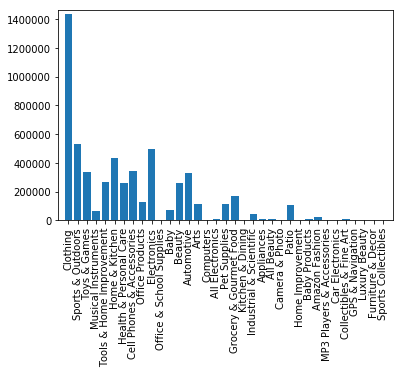

In [5]:
# Plot the distribution
plt.bar(range(1,len(yy)+1), yy)
labels = xx
plt.xticks(range(1,len(yy)+1), labels, rotation='vertical')
plt.margins(0.02)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

In [0]:
# Calculate weights for categories
# Need an even distributed dataset - all categories should have approx. same number of instances
def calc_weight(label):
    wt = 1/int(yy[np.where(xx==label)])
    return wt

In [0]:
df['weight'] = df.label.apply(calc_weight)

In [8]:
# Sum of all the weights should be equal to the number of categories
sum(df.weight)

34.99999999981303

In [0]:
# The distribution is uneven, assign weights and subsample unevenly
df2 = df.sample(n=10000, weights='weight', random_state=2)

In [10]:
# See the distribution of the categories
xx = np.array([])
yy = np.array([])
for l in df2.label.unique():
    i = len(df2[df2.label == l])
    print('label = ', l, ' Number of instances = ', str(i))
    xx = np.append(xx,[l])
    yy = np.append(yy,[i])

label =  Home & Kitchen  Number of instances =  328
label =  Sports & Outdoors  Number of instances =  317
label =  Toys & Games  Number of instances =  335
label =  Arts  Number of instances =  333
label =  Musical Instruments  Number of instances =  307
label =  Camera & Photo  Number of instances =  227
label =  Office Products  Number of instances =  317
label =  Kitchen & Dining  Number of instances =  306
label =  Pet Supplies  Number of instances =  323
label =  Cell Phones & Accessories  Number of instances =  297
label =  Health & Personal Care  Number of instances =  295
label =  MP3 Players & Accessories  Number of instances =  286
label =  Patio  Number of instances =  286
label =  Collectibles & Fine Art  Number of instances =  311
label =  Grocery & Gourmet Food  Number of instances =  304
label =  Computers  Number of instances =  285
label =  Amazon Fashion  Number of instances =  286
label =  Luxury Beauty  Number of instances =  263
label =  Car Electronics  Number of

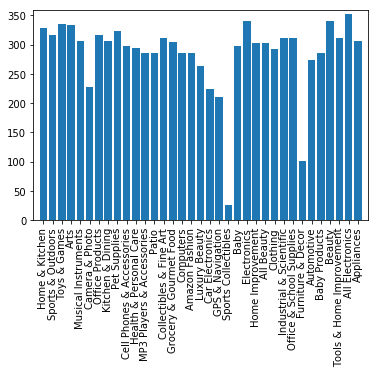

In [11]:
# Plot the distribution
plt.bar(range(1,len(yy)+1), yy)
labels = xx
plt.xticks(range(1,len(yy)+1), labels, rotation='vertical')
plt.margins(0.02)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

In [0]:
# Next step is to download the images
if (not os.path.exists('./images/')):
    !mkdir 'images'

In [0]:
imUrls = df2.imUrl.tolist()
asins = df2.asin.tolist()

# %%time
for url_id in zip(imUrls, asins):
    url = url_id[0] # url of image
    asin = url_id[1] # asin of image
    filename = './images/' + asin + '.jpg'
  
    # also check if file exists. If it does, do not reload it!
    if (not os.path.isfile(filename)):
        try:
            r = requests.get(url, allow_redirects=True)
            open(filename, 'wb').write(r.content)
            
        except Exception as e:
            df2 = df2[df2.asin != asin]           # if missing, remove from dataset
            with open("./missing.txt", "a") as f:
                f.write(asin+'\n')

In [14]:
from tqdm import tqdm
from PIL import Image

for url_id in tqdm(zip(imUrls, asins)):
    url = url_id[0] # url of image
    asin = url_id[1] # asin of image
    filename = './images/' + asin + '.jpg'
    
    try:
        img = Image.open(filename)
    except Exception as e:
        df2 = df2[df2.asin != asin]           # if missing, remove from dataset
        with open("./missing_imgs.txt", "a") as f:
            f.write(asin+'\n')


10000it [00:01, 7808.81it/s]


In [0]:
df2 = df2[['asin', 'label']].copy()

In [16]:
len(df2)

9871

In [0]:
tfms = get_transforms(max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = ImageDataBunch.from_df('./', df2, folder='images', suffix='.jpg', ds_tfms=tfms, size=224, bs=128).normalize(imagenet_stats)

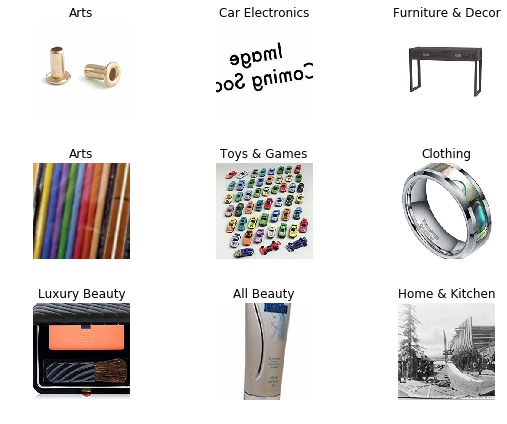

In [21]:
src.show_batch(rows=3, figsize=(8,6))

In [22]:
gc.collect()

print(src.classes)
len(src.classes),src.c

['All Beauty', 'All Electronics', 'Amazon Fashion', 'Appliances', 'Arts', 'Automotive', 'Baby', 'Baby Products', 'Beauty', 'Camera & Photo', 'Car Electronics', 'Cell Phones & Accessories', 'Clothing', 'Collectibles & Fine Art', 'Computers', 'Electronics', 'Furniture & Decor', 'GPS & Navigation', 'Grocery & Gourmet Food', 'Health & Personal Care', 'Home & Kitchen', 'Home Improvement', 'Industrial & Scientific', 'Kitchen & Dining', 'Luxury Beauty', 'MP3 Players & Accessories', 'Musical Instruments', 'Office & School Supplies', 'Office Products', 'Patio', 'Pet Supplies', 'Sports & Outdoors', 'Sports Collectibles', 'Tools & Home Improvement', 'Toys & Games']


(35, 35)

In [0]:
learn = cnn_learner(src, models.resnet34, metrics=error_rate)

In [24]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.513490,2.809189,0.761905,01:03
1,2.964660,2.655221,0.741641,01:03
2,2.636496,2.603811,0.735056,01:06
3,2.428785,2.594661,0.721378,01:02


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
losses,idxs = interp.top_losses()

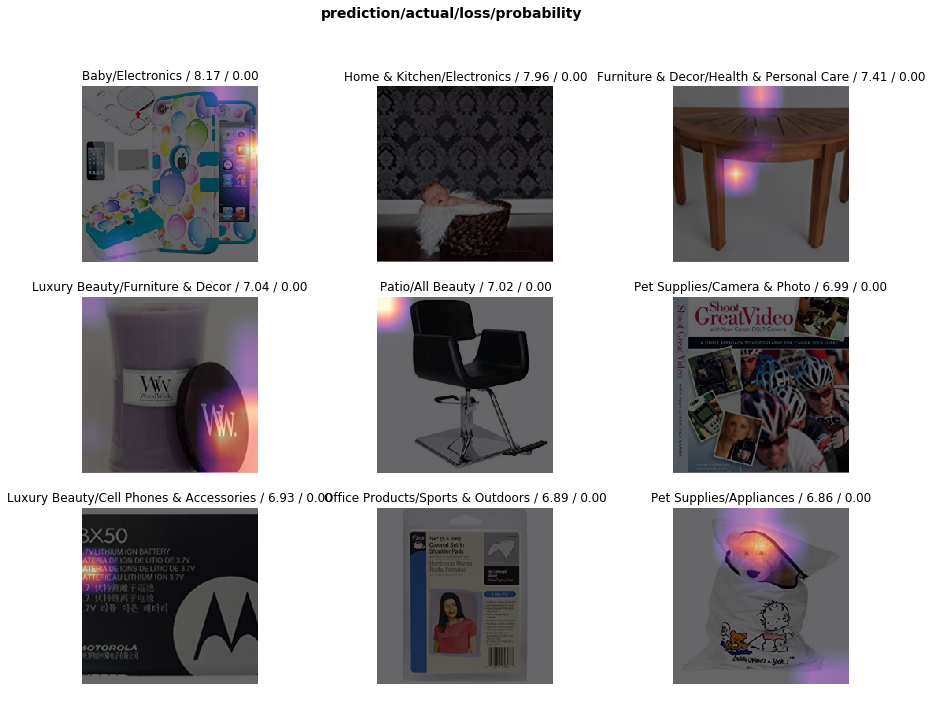

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

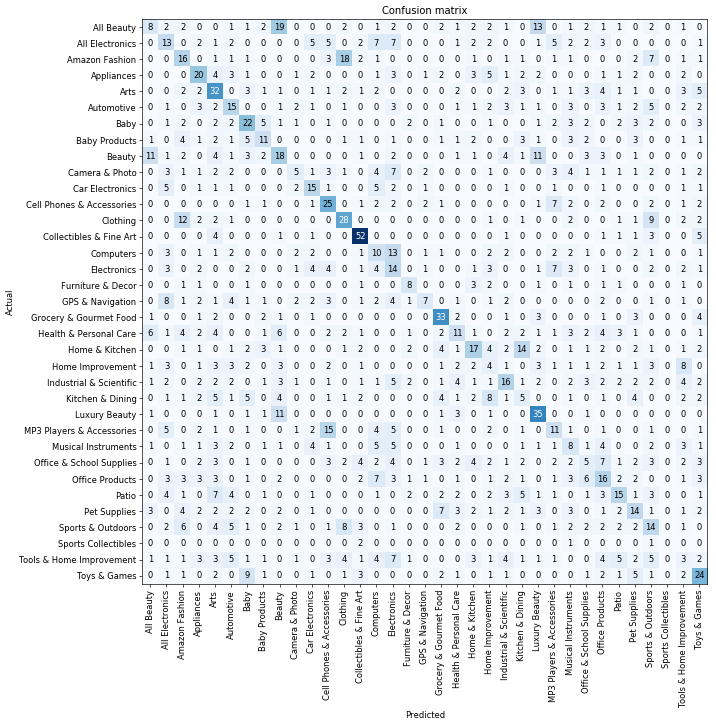

In [28]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)